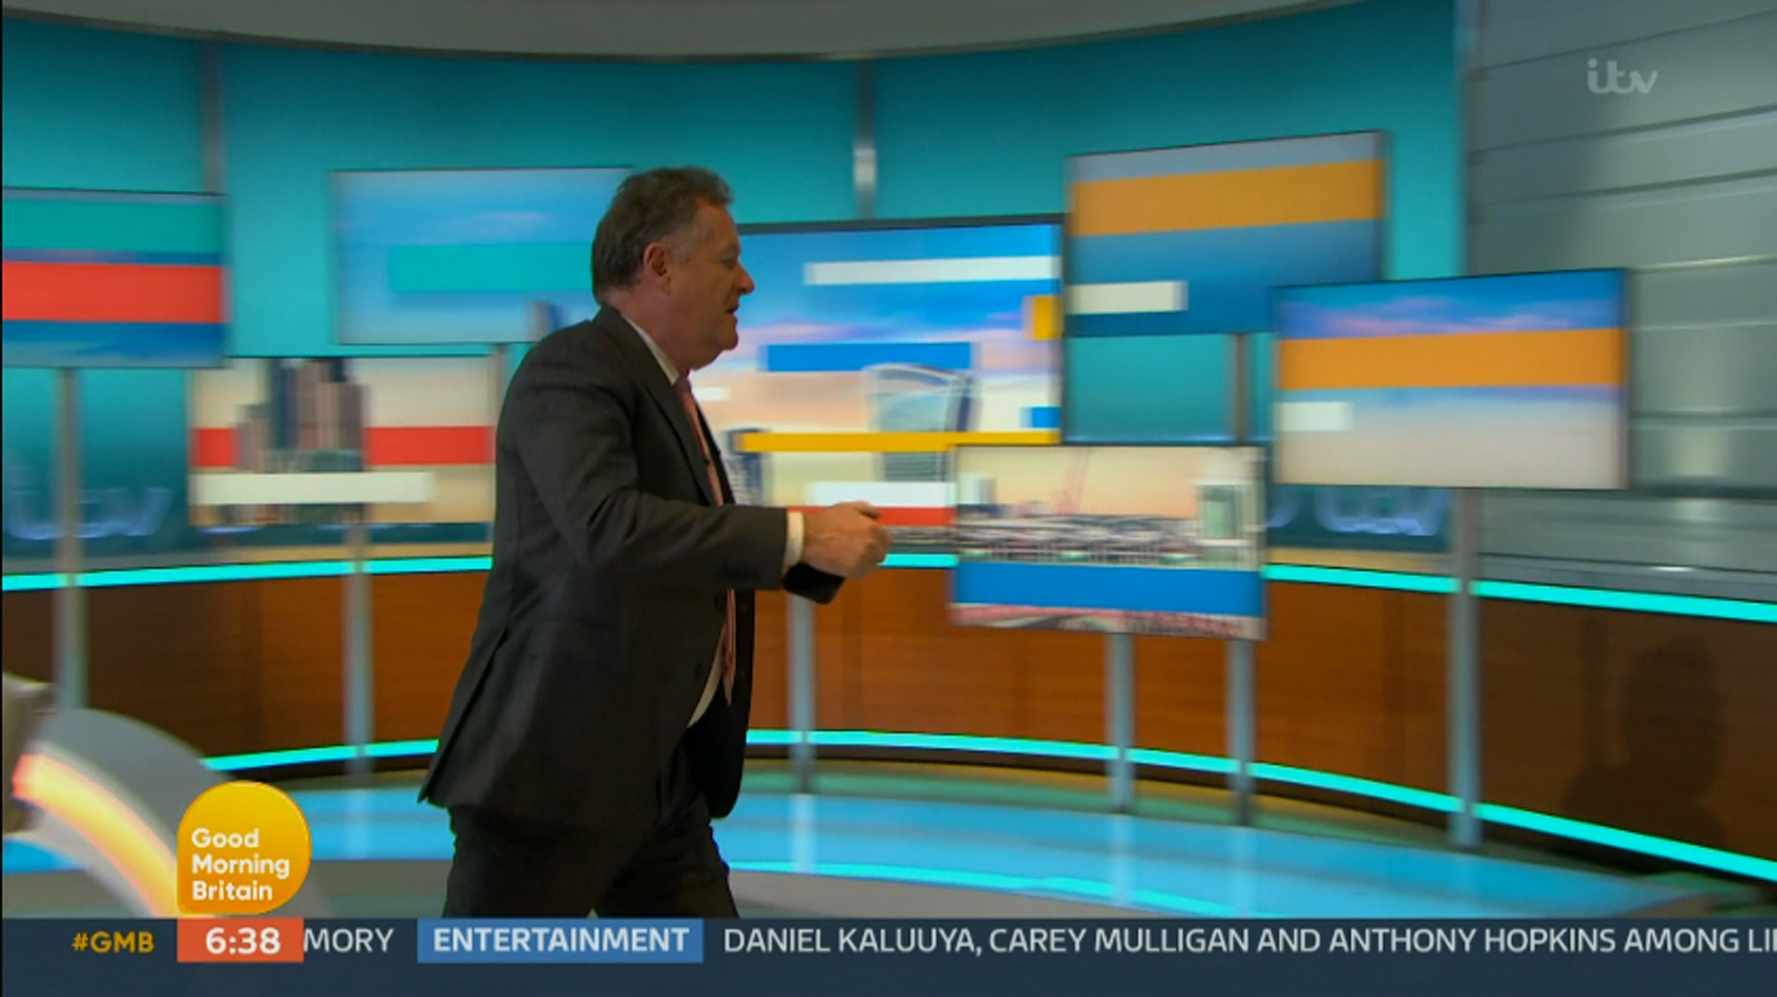

# 1. Introduction

### 1.1 Overview

In this study, we will download and clean tweets for a specified Twitter user. We will then identify common topics in tweets and investigate trends in tone and sentiment.

### 1.2 Background

Over the last decade, the number of individuals using social media has risen from 0.97 to 3.09 billion. Although social media websites vary in design, they share the same basic framework: A user creates an account that becomes their online identity, this user can then publish data through their account page and interact with other account pages. The popularity of social media has produced an enormity of novel data, creating an exciting new domain for data inference.

Analyzing and understanding social media data can provide valuable insights for research purposes. For example, monitoring the number of mentions can quantify public engagement on a particular subject. Similarly, analyzing user image data to determine which clothes are popular amongst certain demographics can be used to create bespoke advertising to key user groups. One valuable application of social media data is sentiment analysis.

Sentiment analysis is described as:

*“The process of computationally identifying and categorizing opinions expressed in a piece of text, especially to determine whether the writer’s attitude towards a particular topic, product, etc. is positive, negative, or neutral.”* — Oxford English Dictionary

The three main types of sentiment analysis approaches are rule-based, automatic, and hybrid. Rule-based methods perform sentiment analysis based on a set of manually crafted rules. For example, you can assign sentiment scores to particular words such as “great” or "terrible", and calculate sentiment based on keyword prevalence. Automatic approaches rely on machine learning techniques to learn from data e.g. a classification problem where a model is trained on data with labeled sentiments. Hybrid approaches use a combination of rule-based and automatic methods.

### 1.3 Data

All data from this project will be mined from Piers Morgan's Twitter account using the Tweepy API and a Twitter developer account.

## 2. Data mining

### 2.1 Tweet extraction

Before we can perform any sort of analysis, we first need to mine data from Twitter. For this we will use the Tweepy API. Tweepy is an open source Python package that can be used to retrieve, like, create, delete, and retweet tweets using HTTP endpoints. A detailed guide on how to use Tweepy can be found [here](https://docs.tweepy.org/en/v3.5.0/getting_started.html).


Tweepy requires you to have a twitter developer account before use. Let's assign our credentials so we can handle requests using `Tweepy`:

In [80]:
#load libraries
import tweepy
import pandas as pd
print("Modules Loaded!")

#assign credentials (insert your own)
consumer_key    = "XXXXXX" 
consumer_secret = "XXXXXX"
access_token    = "XXXXXX"
access_token_secret    = "XXXXXX"

#authorize our twitter credentials
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)
print("Twitter Authorised!")

Modules Loaded!
Twitter Authorised!


Now let's download the tweets from a specified user. For this project we will be analysing tweets from the prolific, yet controversial journalist Piers Morgan:

In [81]:
#specify twitter account to mine
screen_name = "piersmorgan"

#initialize a list to hold all the tweepy Tweets
all_tweets = []     
new_tweets = api.user_timeline(screen_name = screen_name,count=200)
all_tweets.extend(new_tweets)
oldest = all_tweets[-1].id - 1

while len(new_tweets) > 0:
    new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest, exclude_replies = True, include_rts = False)
    all_tweets.extend(new_tweets)
    oldest = all_tweets[-1].id - 1

#show total tweets downloaded
print(f"{len(all_tweets)} Total tweets downloaded!")

2423 total tweets downloaded


We have downloaded a total of 2423 tweets from Piers' user account. Let's load relevant data into a pandas dataframe:

In [82]:
#import pandas
import pandas as pd

#create arrays for pandas
outtweets = [[tweet.id_str, 
              tweet.created_at, 
              tweet.favorite_count, 
              tweet.retweet_count, 
              tweet.text.encode("utf-8").decode("utf-8")] 
             for idx,tweet in enumerate(all_tweets)]

#load arrays into df
df = pd.DataFrame(outtweets,columns=["id","created_at","favorite_count","retweet_count", "text"])

#show df
df.head()

,id,created_at,favorite_count,retweet_count,text
0,1374481780204441601,2021-03-23 22:02:47,9584,223,Love you @kategarraway 🙏 https://t.co/R8w5VDKjUa
1,1374478541442535425,2021-03-23 21:49:55,3515,95,Thank you. This is a perfect summary of what w...
2,1374471065980739586,2021-03-23 21:20:13,17043,367,This is heart-breaking. 💔\n#FindingDerek @kate...
3,1374439337723527178,2021-03-23 19:14:08,4236,103,"Insane. \nThank you so much, again, for the su..."
4,1374433993873973267,2021-03-23 18:52:54,4536,244,Devastating. How many more hearts have to be b...


The table above shows Pier's tweet data across 5 variables: `id`, `created_at`, `favorite_count`, `retweet_count`, and `text`.

### 2.2 Data cleansing

Tweets need to be cleaned before sentiment and tone can be analyzed. Elements like emojis, hyperlinks, and hashtags can impair canonical string classification algorithms. Certain algorithms can interpret Unicode, such as `Qblocks`, but we won't be using any of these in our project. Let's remove any unwanted elements from our tweets by creating two functions: one to remove leading punctuation, and another to replace unwanted elements such as @mentions, retweets, and emojis with blanks:

In [1]:
#load dataset into dataframe
import pandas as pd

#remove leading punctuation
def remLdTxt(text):
    rem_char = [":",",","."," ",]
    i = 0
    for val in text:
        if val in rem_char:
            i +=1
        else:
            break
    return text[i:]
        
#function to clean tweets
def cleanTxt(text): #https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082
    import re
    text = str(text)
    text = text.encode('ascii', 'ignore').decode('ascii') #Remove emoji
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
    text = re.sub('amp', 'and', text) # Removing '#' hash tag
    text = text.replace('&', '')
    text = text.replace('\n', '')
    text = text.replace('*', ' ')
    text = remLdTxt(text)
    return text


#clean the tweets
df['text_clean'] = df['text'].apply(cleanTxt)

#show the cleaned tweets
print("Original tweet: '", df.text[21],"'", "\nCleaned tweet : '", df.text_clean[21],"'")

Original tweet: ' What a generous piece, thanks Mark. 👍 https://t.co/N8g6xpFUCG ' 
Cleaned tweet : ' What a generous piece, thanks Mark.   '


Comparing the output we can see that the emojis and hyperlinks have been removed from the cleaned string.

## 3. Exploratory data analysis

In contrast to smaller more structured datasets, large string-based datasets often contain high volumes of unique values per dataset. This makes the visualization of word distributions challenging, as it's almost impossible to fit all the words used into one interpretable graph. Popular techniques for visualizing text data such as heatmaps and circle packing focus on visualizing the proportional representation of the most prevalent words in a dataset.

### 3.1 Wordcloud

Another common visualization technique are WordClouds. A WordCloud is a collection (or cluster), of words depicted in different sizes. The bigger and bolder the word appears, the more often it’s mentioned within a given text. WordClouds are a simple yet eye-pleasing way to visualize word distributions. 

Let's prepare data for the WordCloud by creating a list of all words which appear in Piers' tweets:

In [3]:
#import libraries
import re

#create list of words
out = []
for tweet in df.text:
    out.append(re.sub("[^\w]", " ",  tweet).split())

#remove unwated elements from text
rem_words = ['https', 'amp', 'co'] #amp = & and https/co are hyperlink artefacts
words = [x for x in out for x in x if len(x) > 1 and x not in rem_words] #remove unwanted single characters or punctuation
print("Total words in list: ", len(words))

Total words in list:  26766


Now let's create a WordCloud from our word list:

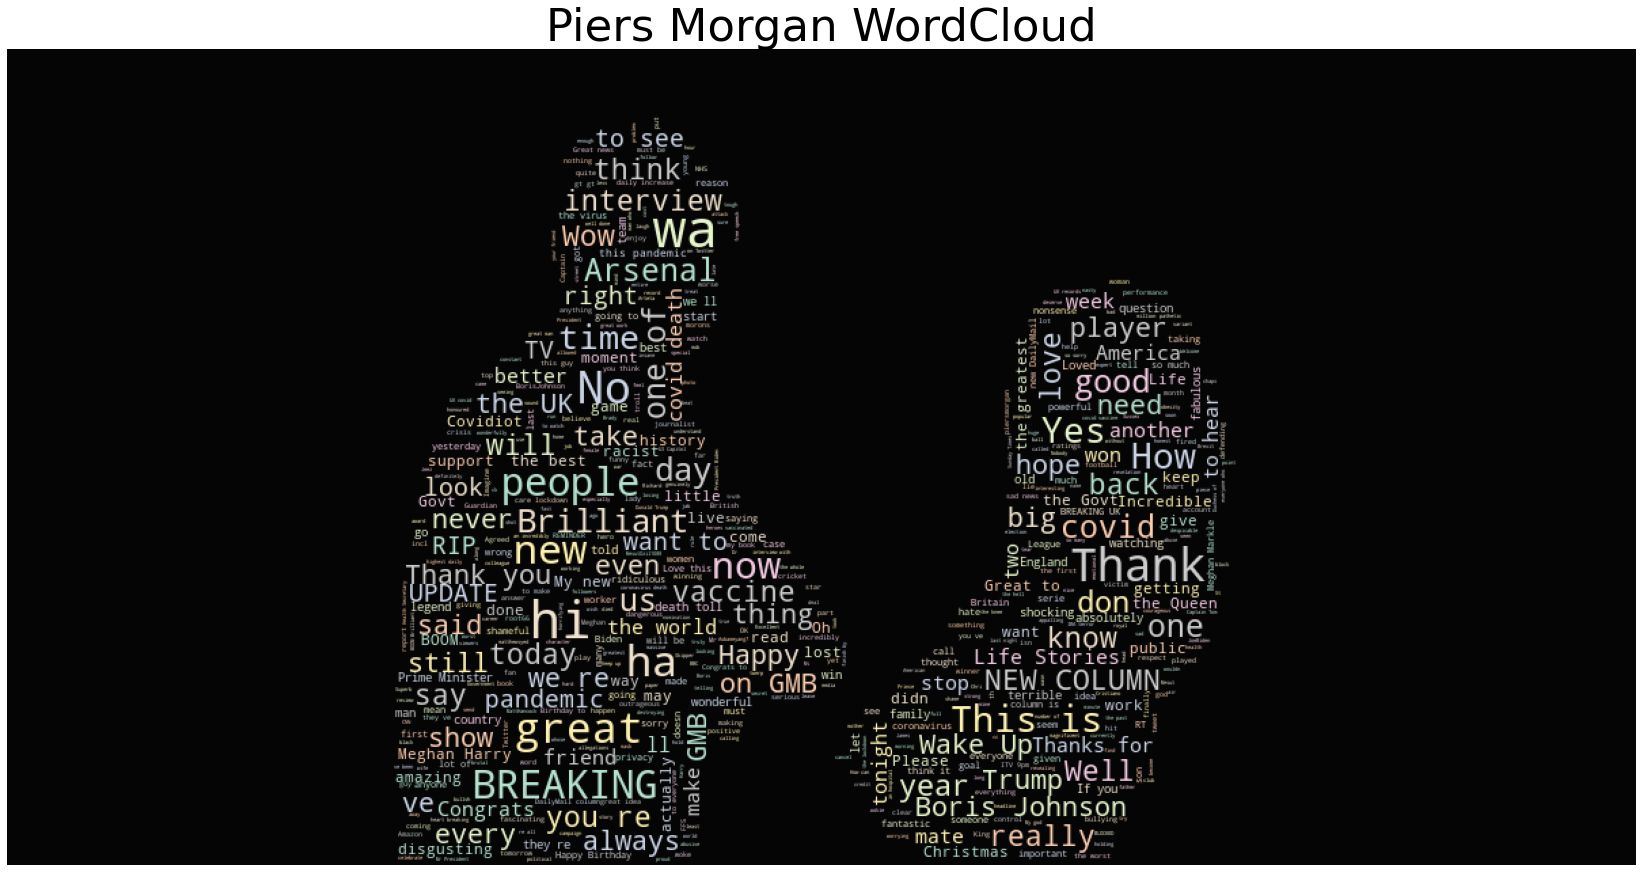

In [4]:
#import libraries
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

#load image for wordcloud mask
pm_img = plt.imread(r"D:\DSProjects\Data_Science\Quick Projects\Twitter_sentiment_analysis\pm.jpg")

# The worldcloud for MMFOOD
plt.figure(figsize=(50,15))
wc = WordCloud(background_color="black", max_words=1000, stopwords=STOPWORDS, max_font_size= 40, mask = pm_img)
wc.generate(" ".join(words))
plt.title("Piers Morgan WordCloud", fontsize=45)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')
plt.show()

The above WordCloud shows prevalent words in our word list. We can see words such as 'Thank', 'BREAKING', 'NEW', 'Trump', 'President', 'vaccine', 'UPDATE' are amongst the most prevalent in our dataset.

## 3.2 Sentiment analysis using VADER

**VADER**

VADER (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.  A sentiment lexicon is a list of lexical features (e.g., words) that are generally labeled according to their semantic orientation as either positive or negative. The sentiment score of a text can be obtained by summing up the intensity of each word in the text. For example - words like ‘love’, ‘enjoy’, ‘happy’, ‘like’ all convey a positive sentiment. VADER is intelligent enough to understand the basic context of these words, such as “did not love” as a negative statement. It also understands the emphasis of capitalization and punctuation, such as “ENJOY”.

Let's look at an example of sentiment scoring using one sentence in `text_clean`:

In [5]:
#load libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#assign VADER sentiment analysis
sid = SentimentIntensityAnalyzer()
sentence = df.text_clean[30]

#run example sentence through sentiment analyser
print("Sentence to be analysed: '", sentence,"'")
print("VADER scores           :", sid.polarity_scores(sentence))

Sentence to be analysed: ' Thanks mate! Very kind.  '
VADER scores           : {'neg': 0.0, 'neu': 0.225, 'pos': 0.775, 'compound': 0.7836}


In the example Piers is giving thanks.  VADER correctly identifies the positive sentiment of the sentence, with a `pos` score of 0.775.

**Sentiment visualization**

Let's view the distribution of sentiment scores across all of our tweets. We will remove tweets with sentiment scores of 0. This is where the algorithm hasn't been able to classify any significant sentiment in the string:

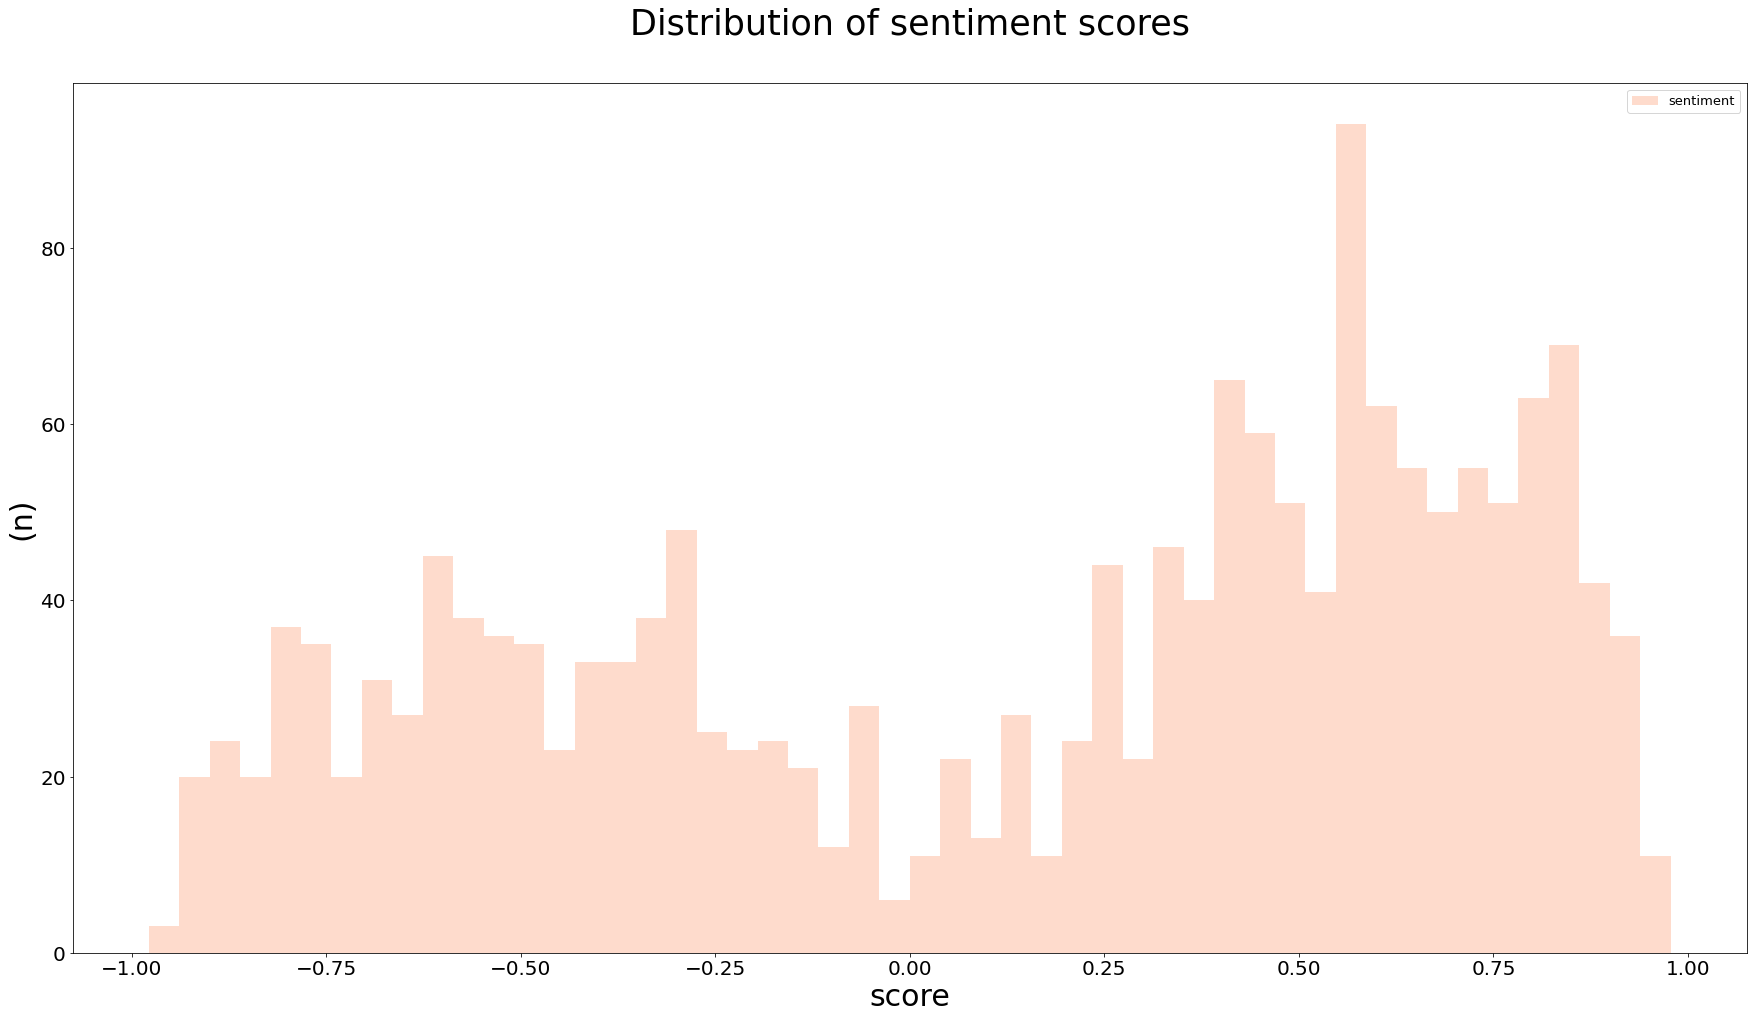

In [13]:
#import module
import seaborn as sns
import matplotlib.pyplot as plt

#loop through tweets and append scores to dataframe
out = []
for sentence in df.text_clean.values:
    out.append(sid.polarity_scores(sentence)['compound'])
df['sentiment'] = out

#set seaborn style
sns.set_palette('Reds')

#remove rows with sentiment score of 0
df_sen = df.query('sentiment != 0')
df_sen = df_sen.reset_index(drop = True)

#print mean sentiment scores
df_sen.sentiment.plot.hist(figsize = (30,16), bins = 50)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("(n)", fontsize = 30)
plt.xlabel("score", fontsize = 30)
plt.title('Distribution of sentiment scores', fontsize = 35, y = 1.05, x = 0.5)
plt.legend(fontsize = 13)
plt.show()

The above histogram shows the distribution of non-zero sentiment scores. We can see there are similar distributions of positive and negative sentiment scores, slightly in favor of positive scores. Let's see if this is reflected in the average sentiment scores:

In [12]:
#calculate mean and median sentiment scores
print("mean sentiment score   :", df_sen.sentiment.mean())
print("median sentiment score :", df_sen.sentiment.median())

mean sentiment score   : 0.1440180102915954
median sentiment score : 0.3182


Scored tweets have mean and median sentiment scores of 0.15 and 0.32 in respective order. The fact that the median is larger than the mean supports the right-skew seen in the histogram. 

## 2.3 Topic-based sentiment analysis

spaCy is a free, open-source library for advanced Natural Language Processing (NLP) in Python. It can be used to build information extraction / natural language understanding systems, or to pre-process text for deep learning. The library works by splitting string into lists of words in a process known as tokenization. Once tokenized spaCy can parse and tag a given string and make contextual predictions about tokens using statistical models.

Let's look at an example of how spaCy tags text:

In [13]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
doc = nlp(df_sen.text_clean[18])
displacy.render(doc, style="dep")

The output shows spaCy has tagged individual words and identified relationships between words in the string.

Our WordCloud highlighted prevalent words in Piers' tweets. Next, we will use SpaCy's entity labeling functionality to identify common topics and visualize word abundance in a chart:

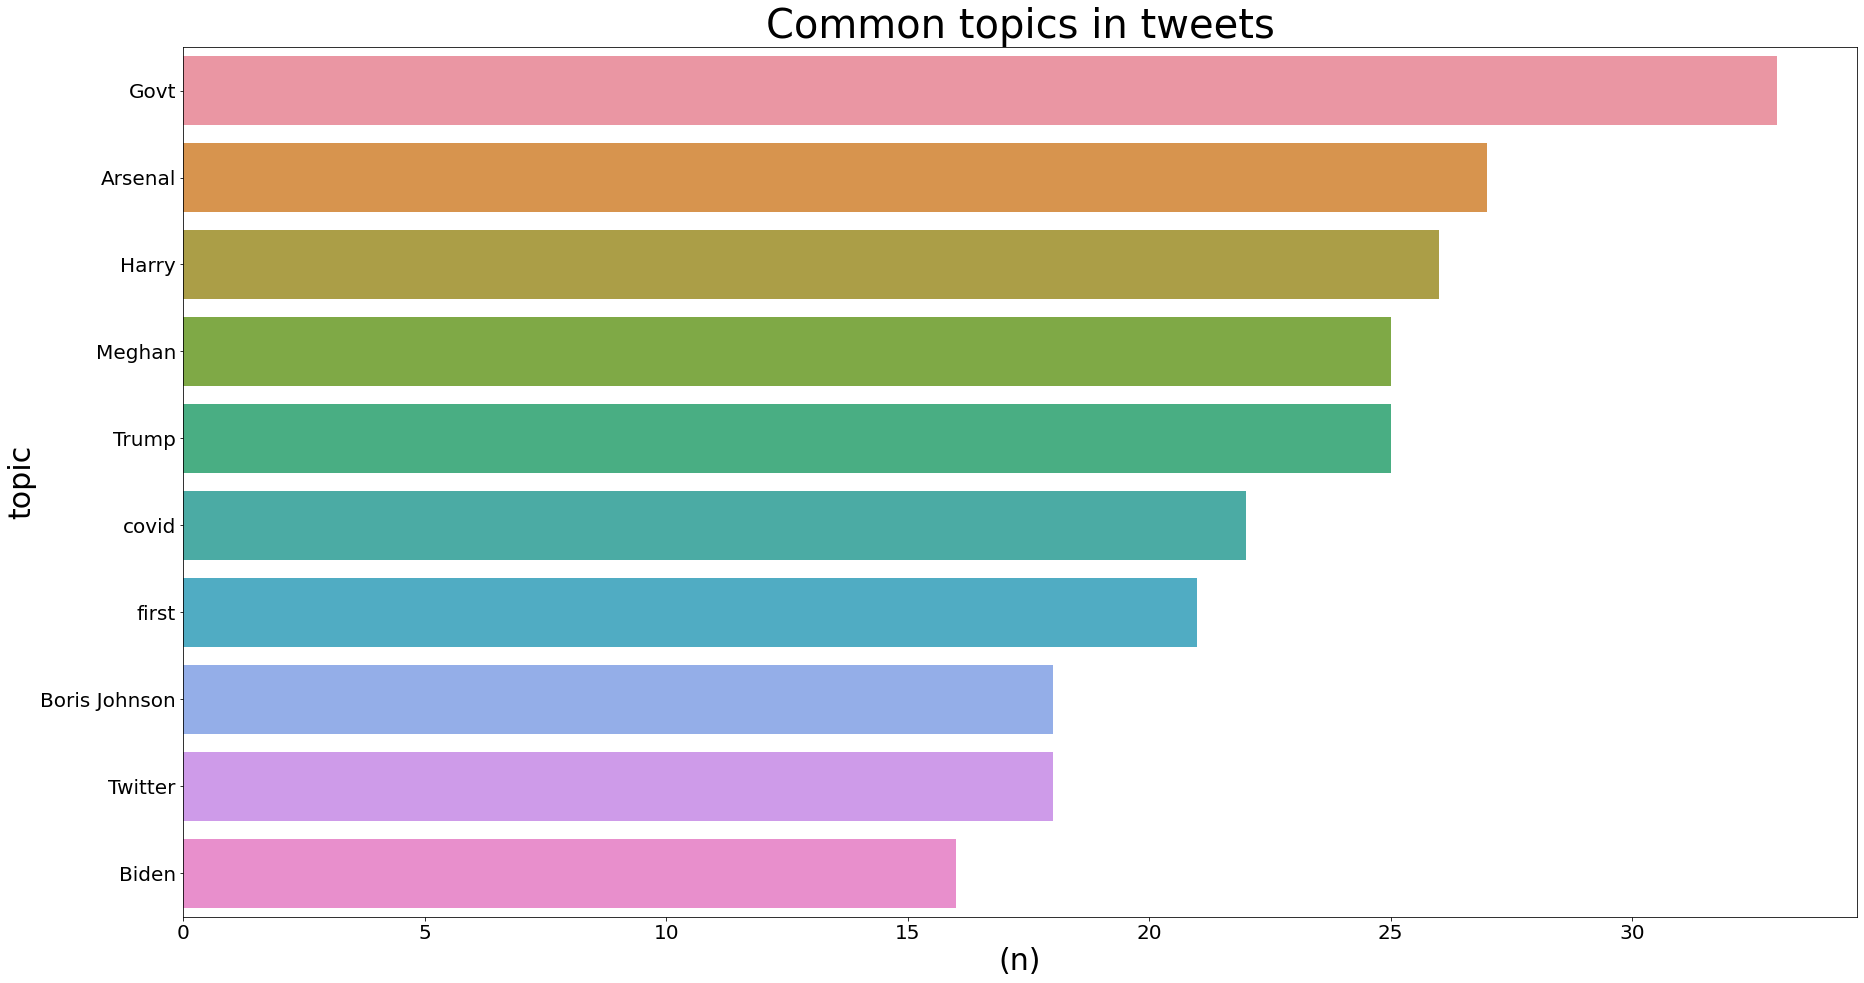

In [11]:
#load SpaCy model
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_lg')

#SpaCy can only handle up to 1M chars
max_length = 1000000-1

#create text variable and slice to less than 1M chars
df_text = df['text_clean'].str.cat(sep=' ')
df_text = df_text[:max_length]

#load text into SpaCy model
doc = nlp(df_text)

#extract nouns
items_of_interest = list(doc.noun_chunks)

#identify items of interest
items_of_interest = [str(x) for x in items_of_interest]

#load library
import seaborn as sns
sns.set_palette('Reds')

#loop through topcis
piers_topics = []
for ent in doc.ents:
    if ent.label_ not in ["PERCENT", "CARDINAL", "DATE"]:
        piers_topics.append(ent.text.strip())

#create df of topic and counts    
df_ttopics = pd.DataFrame(piers_topics, columns=["count"])

#view df as graph
plt.figure(figsize=(30,16))
sns.countplot(y="count",
             data=df_ttopics,
             order=df_ttopics["count"].value_counts().iloc[1:11].index)

#format chart area
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("topic", fontsize = 30)
plt.xlabel("(n)", fontsize = 30)
plt.title("Common topics in tweets", fontsize = 40)

#show plot
plt.show()

The horizontal bar chart shows the most common topics in Piers' tweets. Govt was the most prevalent topic with over 30 appearances in Piers' tweets. There are two major themes: politics, and the royal family. These themes cover 6 of the 10 topics. The outstanding topics appear to have no obvious connection.

We can infer Piers' feeling on a subject by averaging the sentiment scores for a given topic. Let's average sentiment scores for each topic and visualize the output in a chart:

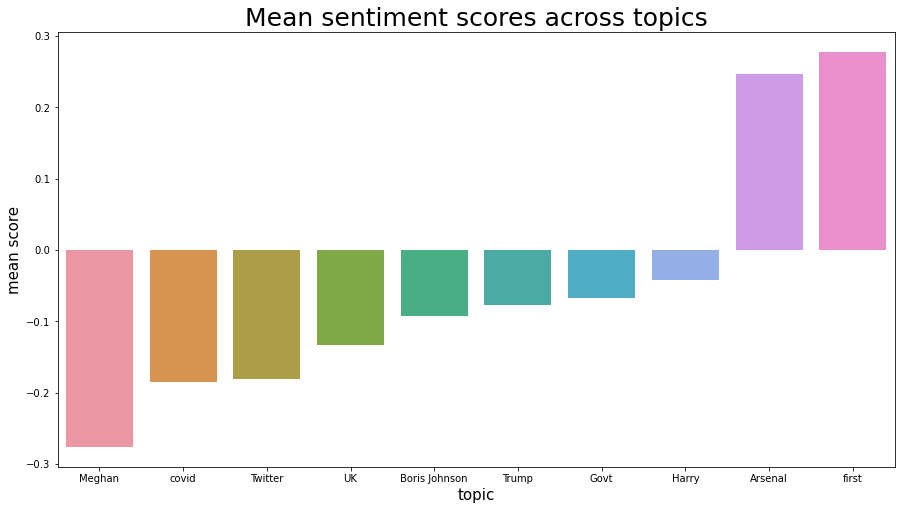

In [41]:
#create df 
top10_df = pd.Series(piers_topics).value_counts()[0:10].index.tolist()

#loop through nouns 
noun_list = []
mean_score = []
for val in top10_df:
    temp_df = df_sen[df_sen['text'].str.contains(val)]
    noun_list.append(val)
    mean_score.append(temp_df.sentiment.mean())

#create df of noun scores
sentiment_score_df = pd.DataFrame({'mean_score':mean_score}, index = noun_list).sort_values(by='mean_score', ascending = True)

#create plot
plt.figure(figsize=(15,8))
sns.barplot(x = sentiment_score_df.index, y = sentiment_score_df.mean_score)

#format chart area
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("topic", fontsize = 15)
plt.ylabel('mean score', fontsize = 15)
plt.title("Mean sentiment scores across topics", fontsize = 25)
plt.show()

The figure above shows the mean sentiment scores for prevalent topics identified using spaCy. The majority of topics had negative mean sentiment scores ranging from -0.28 to -0.15. 'Arsenal' and 'first' were the only two topics with positive sentiment scores of 0.25 and 0.28 respectively.

## 2.4 Tone analysis using IBM Watson's Tone Analyzer

The IBM Watson™ Tone Analyzer service uses linguistic analysis to detect emotional and language tones in written text. The service can analyze tone at both the document and sentence levels. Tone Analyzer can identify 7 common tones: anger, fear, joy, sadness, confident, analytical, and tentative. Let's use the Tone Analyzer to classify tones in our tweets.

**Authentication**

First we need to authenticate use of the API:

In [90]:
#import libraries
from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

#specify API credentials
apikey = 'XXXXXXX'
url = 'XXXXXX'

#authenticate credentials
authenticator = IAMAuthenticator(apikey)
ta = ToneAnalyzerV3(version='2017-09-21', authenticator = authenticator)
ta.set_service_url(url)

#show api set
print("authentication complete!")

authentication complete!


**Example output**

Let's look at an example of the output from ToneAnalyzer3:

In [116]:
#test tone
ta.tone('I’m a perfect physical specimen').get_result()

{'document_tone': {'tones': [{'score': 0.872461,
    'tone_id': 'joy',
    'tone_name': 'Joy'},
   {'score': 0.961633, 'tone_id': 'confident', 'tone_name': 'Confident'}]}}

The output shows the emotions detected and associated scores. The algorithm correctly identifies two emotions in the sentence: 'joy' and 'confident'.

**Tone indentification**

Let's use Tone Analyzer to identify tones in `text_clean`. We're only interested in tones that are strongly associated with the string, so we will use a cut-off value of 0.7 for tone inclusion:

In [117]:
#create function determine tone length and split tone and score (above 0.7) into columns
def score_calc(text):
    """
    str -> ([str], [int])
    
    Identify significant tones and tone scores of input text using ToneAnalyzer v3
    
    example: 'I’m a perfect physical specimen' -> (['joy', 'confident'], [0.872461, 0.961633])
    """
    
    out = ta.tone(text).get_result()['document_tone']['tones']
    to, sc  = [], []
    for val in out:
        if val['score'] > 0.7: #0.7 is abitrary significance cut-off
            to.append(val['tone_id'])
            sc.append(val['score'])
    return to, sc


#loop through
import time

#loop through tweets in dataframe
tone = []
score = []
i = 0

for text in df_sen.text_clean:
    res = score_calc(text)
    tone.append(res[0])
    score.append(res[1])
    print("sent request...", i)
    time.sleep(0.05) #sleep to stop request overloading
    i += 1
    
#assign to df
df_sen['tone'] = tone
df_sen['score'] = score

sent request... 0
sent request... 1
sent request... 2
sent request... 3
sent request... 4
sent request... 5
sent request... 6
sent request... 7
sent request... 8
sent request... 9
sent request... 10
sent request... 11
sent request... 12
sent request... 13
sent request... 14
sent request... 15
sent request... 16
sent request... 17
sent request... 18
sent request... 19
sent request... 20
sent request... 21
sent request... 22
sent request... 23
sent request... 24
sent request... 25
sent request... 26
sent request... 27
sent request... 28
sent request... 29
sent request... 30
sent request... 31
sent request... 32
sent request... 33
sent request... 34
sent request... 35
sent request... 36
sent request... 37
sent request... 38
sent request... 39
sent request... 40
sent request... 41
sent request... 42
sent request... 43
sent request... 44
sent request... 45
sent request... 46
sent request... 47
sent request... 48
sent request... 49
sent request... 50
sent request... 51
sent request... 52
sen

Let's look at our newly appended data; we will drop any rows which have no significant tone score:

In [36]:
#drop null values
df = df_sen
df = df.replace("[]", None)
df.dropna(inplace = True)

#view newly appended columns
df[['tone', 'score']].head()

,tone,score
0,['joy'],[0.880435]
1,"['joy', 'confident', 'analytical']","[0.936445, 0.975399, 0.962247]"
2,"['joy', 'confident', 'analytical']","[0.936445, 0.975399, 0.962247]"
3,"['sadness', 'analytical', 'tentative']","[0.876109, 0.736855, 0.949449]"
4,['sadness'],[0.708979]


**Tone analysis**

Two columns for `tone` and `score` have been successfully appended to the data frame. Now let's calculate the tonality of Piers' tweets. To do this we will calculate the mean score for each emotion across the entire data frame. Some tweets have multiple significant tones (see table above). We need to extract all the individual values from lists before calculating average tone scores; let's create two functions to do so:

In [15]:
def str_splitter(val:str):
    """
    Converts list-like str into lists

    "['joy', 'confident', 'analytical']" ->  ['joy', 'confident', 'analytical']

    """
    word = []
    for char in val:
        if char in ["'","[","]"]:
            pass
        else:
            word.append(char)
    word = ''.join(word)
    if "," in word:
        word = word.split(", ")
    return word

def col_splitter(col):
    """
    If value type == list, appends items from value list

    ['joy', 'confident', 'analytical'] ->  ['joy', 'confident', 'analytical']

    ['analytical'] -> ['analytical']

    """
    out = []
    for val in col:
        if type(val) == list:
            for word in val:
                out.append(word)
        else:
            out.append(val)
    return out

Now we've defined our functions we can restructure tonal data into a visualization-friendly format. Let's view the distribution of tone in pier's tweets using a radar chart:

In [37]:
#import packages
import numpy as np

#apply str_splitter
df['tone'] = df.tone.apply(str_splitter)
df['score'] = df.score.apply(str_splitter)

#calculate all tweet scores in descending order
all_score = pd.DataFrame({'tone':col_splitter(df.tone), 'score':[float(x) for x in col_splitter(df.score)]}).groupby('tone').sum().sort_values(by='score', ascending = False)
all_score['score']  = all_score.score/all_score.score.sum() #get proportional scores

#create chart
import plotly.express as px
fig = px.line_polar(all_score, r = 'score', theta = all_score.index, line_close = True)
fig.update_traces(fill='toself')

#format title
fig.update_layout(
    title={
        'text': "Tone distribution",
        'y':1,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        title_font_color="black",)

#show chart
fig.show()

Looking at the radar chart we can see the four dominant tones in Piers tweets: 'tentative', 'analytical', 'confident', and 'joy'. These dominant tones made up the majority of tweets in the distribution, with a collective representation of over 90%. The three less featured scores 'fear', 'anger', and 'sadness had smaller proportional representation with values close to 0.

**Topic-based tone analysis**

Now we have determined the average tone scores we can assess tonal relativity for each of the common topics. To do this we will use the following calculation: (all tweet mean tone score - topic tweet
mean tone score). Let's calculate the relative tone scores for common topics and visualize correlation in a heatmap. We will use Spearman's rank correlation as the data is non-parametric:

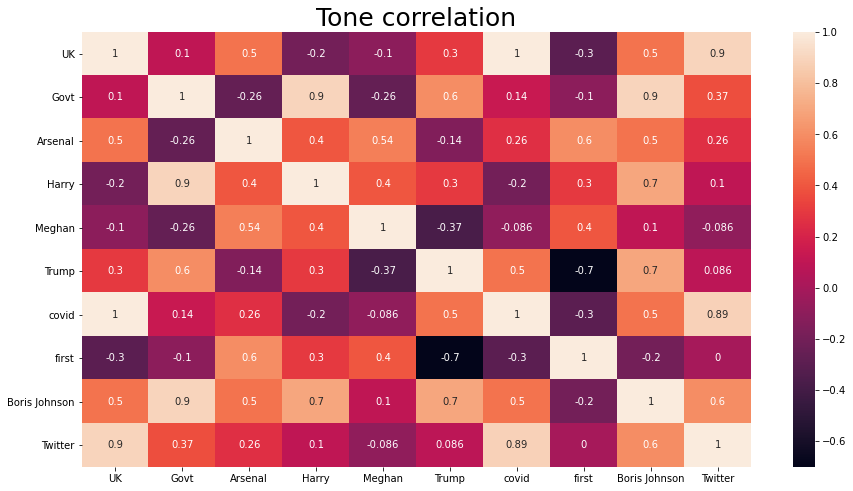

In [46]:
#create empty dictionary
my_dict  = {}

#fill dict keys
idx_vals = pd.Series(col_splitter(df.tone)).unique().tolist()
for idx in idx_vals:
    my_dict.update({idx:[]})
    
#loop through to get mean tone score for each topic and append to dict
noun_list = []
for noun in top10_df:
    temp_df = df[df['text_clean'].str.contains(noun)]
    temp_df_sum = pd.DataFrame({'tone':col_splitter(temp_df.tone), 'score':[float(x) for x in col_splitter(temp_df.score)]}).groupby('tone').mean()
    for idx in idx_vals:
        if idx not in temp_df_sum.index.tolist(): #append null if no tone detected for topic
            my_dict[idx].append(None)
    for idx, val in zip(temp_df_sum.index.tolist(), temp_df_sum.score.tolist()):
        my_dict[idx].append(val)
    noun_list.append(noun)

#create table from dict
table_df = pd.DataFrame(my_dict, index = noun_list)

#create mean dataframe for comparison
mean_df = pd.DataFrame({'tone':col_splitter(df.tone), 'score':[float(x) for x in col_splitter(df.score)]}).groupby('tone').mean()

#subtract mean_df values from table_df values
my_dict  = {}

for col in table_df.columns:
    data = table_df[col].values - mean_df[mean_df.index == col].values
    data = data.tolist()
    data = [x for x in data for x in x]
    my_dict.update({col:data}) 

#create dataframe    
tone_df = pd.DataFrame.from_dict(my_dict)
tone_df.index = table_df.index

#reformat dataframe
tone_df = tone_df.T
tone_df

#create heatmap
plt.figure(figsize = (15,8))
ax = sns.heatmap(tone_df.corr(method = 'spearman'), annot=True)
plt.title('Tone correlation',fontsize = 25)

#show plot
plt.show()

The heatmap shows the correlation between relative tone scores for each common topic. Notably high correlations with values >= 0.6 include: 'UK & Covid', 'UK' & 'Twitter', 'Boris Johnson' & 'Govt', 'Boris Johnson' & 'Harry', 'Arsenal' & 'First', 'Trump' & 'Govt', and 'Boris Johnson' & 'Twitter'. There is strong negative correlation between 'first' and 'Trump', with a pearson rank score of -0.7.

## 3. Discussion

Usage of Tweepy allowed for fast and simplistic extraction of user tweets. Manual extraction would have been untimely and ineffective due to the large volume of tweets being handled. Tweepy was preferred over other APIs such as 'Twint' and the 'Twitter API' for its ease of use and well-documented implementation. Text elements such as emojis, hyperlinks, and hashtags were removed from tweets to enhance the predictive power string classification algorithms. The use of Regex allowed for easy deletion of specific characters within a given string. However, deletion could be heavy-handed at times and removed substantial segments from tweets. Text elements such as @mentions, hyperlinks, and emojis can be integral for understanding subject and sentimentality. Removal of such elements from Tweets (which are already succinct by nature), can leave string devoid of meaning and hard to interpret.

The WordCloud visualized word distributions in the cleaned tweets. More pronounced words were related to either the news (i.e. Trump, vaccine, president...) or common elements in the English language (i.e yes, no, on...). Common elements are inferentially redundant words found in similar abundances within all text. The high volume of common elements generalized the WordCloud and diluted extrapolation of user-specific language.

VADER was used to identify sentiment present in the tweets. Characterized tweets were found to have positive mean and modal sentiment scores, suggesting an overall positive tone to Piers' tweets. Common topics (or prevalent nouns) were identified using spaCy and most could be divided into two main themes: politics, and the royal family.

Calculating the average sentiment scores for each topic created a dataset that could be used to visualize topic subjectivity. The topics 'Meghan' and 'Covid' had the lowest mean sentiment scores. This may be explained by Piers' [recent argument with Meghan Markle](https://www.hollywoodreporter.com/news/piers-morgan-returns-to-bashing-meghan-markle-blames-tyranny-of-woke-mobs-for-tv-exit), and the negative impact that Coronavirus is having across the globe (as of Mar-21). Inversely, 'Arsenal' had a high sentiment score. Piers is an Arsenal fan, which may explain the positive sentiment. The inclusion of the topic 'first' seemed out of place and looks as if spaCy misclassified an ordinal numeral for a noun.

IBM's ToneAnalzyer3 was used to classify the tonality of Piers' tweets. Characterized tweets showed Piers to express four main tones: 'Joy', 'analytical', 'confident', and 'tentative. Relative tone scores for common topics were calculated from the mean tone scores across all tweets. The multidimensional output was difficult to visualize in a conventional graph, so correlation was calculated and shown in a heatmap to analyse variable groupings.  Some highly correlated variables groups appeared in both the tone and sentiment analysis. For example, 'UK', 'Twitter', and 'Covid' had high Pearson correlation scores and appeared next to each other on the sentiment graph. This could imply a relationship between tweet tonality and sentimentality. However, as this was not the case for all highly correlated variable groups, so further research would be necessary to determine the significance of such claims.

The incomplete characterization of tweets limited the inferential potential of the data set. Over 1/4 of tweets could not be classified on either of the sentiment or tone models and were dropped from the datasets. Smaller datasets generally have lower generalizability and can have poorer out-of-sample performance. Generic limitations of string classifiers may have also impacted the accuracy of classification. For example, nuanced language devices such as sarcasm are hard to train and are often misclassified by algorithms. Moreover, both model's inablity to interpret emojis may have cause poorer comprehension of tweet tone and sentiment. 

A logical follow-up to this experiment would be to incorporate non-natural language elements such as emojis and tweets algorithm into the analysis. Translating such elements into words that could be interpreted by classification models could improve the accuracy of analyses from Twitter data.

Overall, we successfully downloaded, characterized, and analysed tweets from a specific Twitter account. Sentiment and tone analysis of tweets provided insights into Piers' feelings on his most commonly discussed topics.